In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

import matplotlib as mpl
mpl.style.use('default')

%matplotlib inline

In [372]:
# Help ensure we do not accidentally make changes to the database if one of our queries has an error
# We can now access 'conn' inside an indented block
# This function takes an SQL query as an argument, returns a pandas Dataframe of that query

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [373]:
# Take SQL command as an argument, execute it using the sqlite module
# Runs commands like "CREATE VIEW"

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None    # Autocommit any changes
        conn.execute(c)

In [374]:
# Call the run_query() function to return a list of all tables and views in the database

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    
    return run_query(q)

In [375]:
# List all of the tables and views in the chinook database

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

Let us say that the Chinook record store has just signed a deal with a new record label, and we have to select the first three albums that will be added to the store from a list of four. All four albums are by artists that don't have any tracks in the store right now. We have the artist names and the genre of music they produce.

In [376]:
new_albums = {'Artist Name': ['Regal', 'Red Tone', 'Meteor and the Girls', 'Slim Jim Bites'],
              'Genre': ['Hip-Hop', 'Punk', 'Pop', 'Blues']}
pd.DataFrame.from_dict(new_albums)

,Artist Name,Genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the US. We want to see which genres sell the best in the US.

In [377]:
usa_best_genre_query = '''
WITH usa_tracks AS
    (
    SELECT il.* 
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT
    g.name Genre,
    COUNT(ut.invoice_line_id) Number_of_Tracks_Sold,
    CAST(COUNT(ut.invoice_line_id) as FLOAT) * 100 / (SELECT COUNT(*) FROM usa_tracks) Percentage
FROM usa_tracks ut
INNER JOIN track t ON ut.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY Percentage DESC
LIMIT 10
'''

genre_sales_usa = run_query(usa_best_genre_query)
genre_sales_usa.set_index("Genre", drop = True, inplace = True)

run_query(usa_best_genre_query)

,Genre,Number_of_Tracks_Sold,Percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


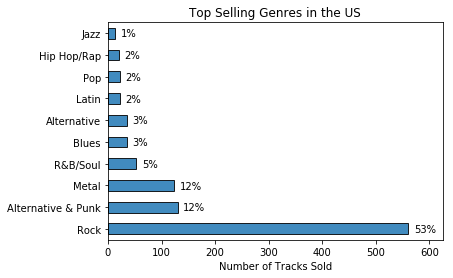

In [378]:
genre_sales_usa.plot.barh(y = 'Number_of_Tracks_Sold', legend = False, 
                          color = 'C0', alpha = .85, edgecolor = 'black', linewidth = 1)
plt.xlabel('Number of Tracks Sold')
plt.ylabel('')
plt.title('Top Selling Genres in the US')
plt.xlim([0, 625])

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, 'Number_of_Tracks_Sold']
    plot_label = '%.0f' % genre_sales_usa.loc[label, 'Percentage']
    plt.annotate(plot_label + '%', (score + 10, i - .15))

The four new albums represent the hip-hop, punk, pop, and blues genres. Based on the metric of percentage of tracks sold by genre in the US, alternative & punk is the most popular of the four, followed by blues and pop. If we say the metric of number of tracks sold by genre is linked to the popularity of the genre, then Chinook should recommend the albums by Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop), in that order. It is noted, however, that the most popular genre in the US is rock, such that rock albums should have priority.

# Analyzing Employee Sales Performance

Let us analyze the purchases of customers belonging to employees to see if any sales support agent is doing better or worse than the others. We can look at the total sales dollars and any extra attributes.

In [379]:
employee_performance_query = '''
WITH customer_purchases AS 
    (
    SELECT
        c.*,
        COUNT(*) number_purchases,
        SUM(i.total) customer_total
    FROM customer c
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.customer_id
    )

SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date Hire_Date,
    SUM(cp.customer_total) Total_Dollar_Amount,
    SUM(cp.number_purchases) Number_of_Purchases,
    COUNT(cp.customer_id) Number_of_Customers
FROM customer_purchases cp
INNER JOIN employee e ON e.employee_id = cp.support_rep_id
GROUP BY employee_name
'''

#employee_performance = run_query(q)
#employee_performance.set_index("employee_name", drop = True, inplace = True)

run_query(employee_performance_query)

,employee_name,Hire_Date,Total_Dollar_Amount,Number_of_Purchases,Number_of_Customers
0,Jane Peacock,2017-04-01 00:00:00,1731.51,212,21
1,Margaret Park,2017-05-03 00:00:00,1584.00,214,20
2,Steve Johnson,2017-10-17 00:00:00,1393.92,188,18


Text(0.5,1,'Sales Representative Performance')

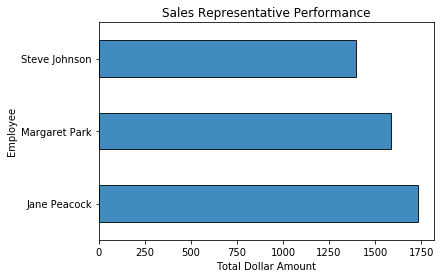

In [380]:
employee_performance.plot.barh(y = 'Total_Dollar_Amount', legend = False, 
                               color = 'C0', alpha = .85, edgecolor = 'black', linewidth = 1)
plt.xlabel('Total Dollar Amount')
plt.ylabel('Employee')
plt.title('Sales Representative Performance')

Jane Peacock and Margaret Park are outperforming Steve Johnson. Jane Peacock has made more money in sales, but Jane and Margaret have had very similar number of transactions and customers. Steve, meanwhile, has made the least amount of money in sales, has made the smallest number of transactions, and has the smallest number of customers. However, this can be attributed to how Steve was hired 5 to 6 months after Jane and Margaret.

# Analyzing Sales by Country

Say we have been directed to calculate data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

It should be noted there are a number of countries with only one customer, so these customers should be grouped into "Other".

In [381]:
country_query = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT 
    country,
    COUNT(distinct customer_id) Total_Number_of_Customers,
    SUM(unit_price) Total_Value_of_Sales,
    SUM(unit_price) / COUNT(distinct customer_id) Customer_Average_Sales_Value,
    SUM(unit_price) / COUNT(distinct invoice_id) Average_Order_Value
FROM 
    (
    SELECT
        coo.*,
        CASE
            WHEN coo.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other coo
    )
GROUP BY country
ORDER  BY sort ASC, Total_Value_of_Sales DESC
'''

sales_by_country = run_query(country_query)
sales_by_country.set_index("country", drop = True, inplace = True)

run_query(country_query)

,country,Total_Number_of_Customers,Total_Value_of_Sales,Customer_Average_Sales_Value,Average_Order_Value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Average Order Value Versus Mean, By Country')

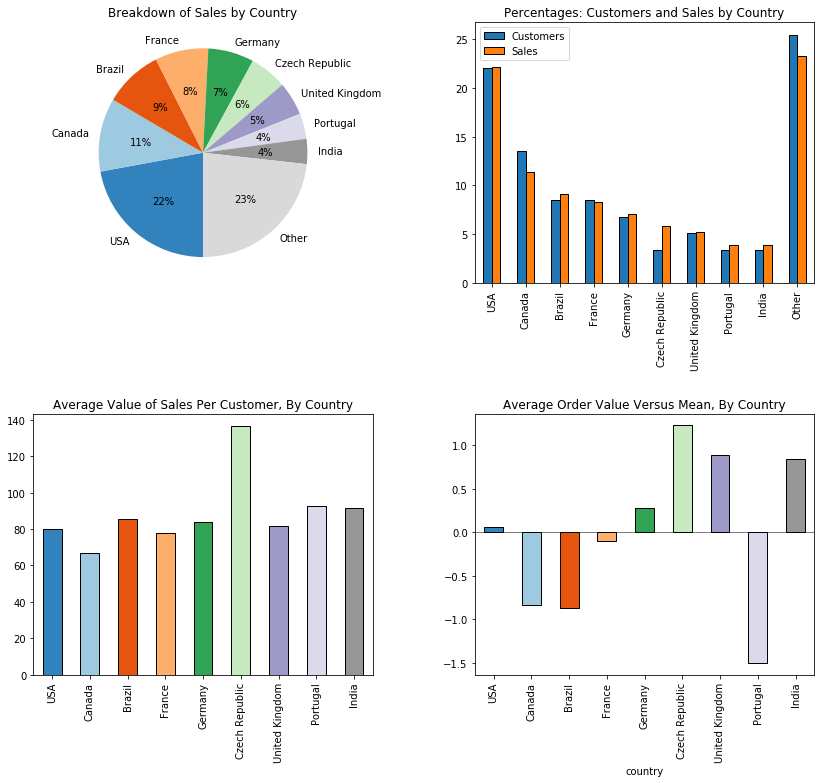

In [382]:
from matplotlib import cm
import numpy as np

color_map = [plt.cm.tab20c(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]

fig = plt.figure(figsize = (14, 12))
fig.subplots_adjust(hspace=.5, wspace=.3)

# Top Left: Breakdown of the total sales by country
ax1 = fig.add_subplot(221, aspect = 1)
ax1.pie(sales_by_country['Total_Value_of_Sales'], 
        labels = sales_by_country.index, autopct = '%.0f%%', colors = color_map,
        counterclock = False, startangle = -90)
ax1.set_title('Breakdown of Sales by Country')

# Top Right: Percentages of customers and total sales by country
ax2 = fig.add_subplot(222)
cust_sales_col = ['Total_Number_of_Customers', 'Total_Value_of_Sales']
cust_sales = sales_by_country[cust_sales_col]
for c in cust_sales_col:
    cust_sales[c] = cust_sales[c] / cust_sales[c].sum() * 100
cust_sales.plot.bar(ax = ax2, linewidth = 1, edgecolor = 'black')
ax2.set_xlabel('')
ax2.set_title('Percentages: Customers and Sales by Country')
ax2.legend(['Customers', 'Sales'])

# Bottom Left: Customers
ax3 = fig.add_subplot(223)
customer_average_sales = sales_by_country.loc['USA':'India', 'Customer_Average_Sales_Value']
customer_average_sales.plot.bar(ax = ax3, color = color_map, 
                                edgecolor = 'black', linewidth = 1)
ax3.set_xlabel('')
ax3.set_title('Average Value of Sales Per Customer, By Country')

# Bottom Right: Average value of order
ax4 = fig.add_subplot(224)
average_value_order = sales_by_country.loc['USA':'India', 'Average_Order_Value']
average_value_order -= average_value_order.mean()
average_value_order.plot.bar(ax = ax4, color = color_map,
                             edgecolor = 'black', linewidth = 1)
ax4.axhline(0, 0, 1, lw = 1, color = 'black', alpha = .5)
ax4.set_title('Average Order Value Versus Mean, By Country')

Most of the sales and customers are from the United States. A few customers from other countries have been using Chinook, and there is potential for growth in some of these countries, namely:
- Czech Republic
- India
- United Kingdom

6% of the sales are from the Czech Republic, but this country has the highest reported average value of sales per customer and average order value. Even if the customer base remains small, the sales from this country may continue to be high if sales grow. Two other countries that show potential for growth are the United Kingdom (currently 5% of the sales) and India (currently 4% of the sales), based on the average value of sales per customer and average order value. Portugal also has a high value for the average value of sales per customer, but the average order value is significantly below the mean.

# Albums vs Individual Tracks

We want to see what percentage of purchases are individual tracks vs whole albums (can affect purchasing strategy (get only popular tracks of album versus full album)). 

Going to have to identify whether each invoice has all tracks from an album: Get list of tracks from an invoice and compare with list of tracks from an album. Can find album by checking the album of a purchased track.

We are going to categorize each invoice as an album purchase or not. We'll look at the number of invoices that are album purchases, and the percentage.

In [462]:
album_or_not = '''
WITH
    invoice_with_albums AS
        (
        SELECT
            il.*,
            t.album_id
        FROM invoice_line il
        INNER JOIN track t ON t.track_id = il.track_id
        ORDER BY il.invoice_id
        ),
    probe_album AS
        (
        SELECT
            i.invoice_id,
            CASE
                WHEN
                    (
                    SELECT track_id FROM invoice_with_albums
                    WHERE invoice_id = i.invoice_id
                    EXCEPT
                    SELECT track_id FROM track
                    WHERE album_id = i.album_id
                    ) IS NULL
                    AND
                    (
                    SELECT track_id FROM track
                    WHERE album_id = i.album_id
                    EXCEPT
                    SELECT track_id FROM invoice_with_albums
                    WHERE invoice_id = i.invoice_id
                    ) IS NULL THEN "Yes"
                ELSE "No"
            END AS Album_Purchase
        FROM invoice_with_albums i
        ),
    album_or_not AS
        (
        SELECT * FROM probe_album
        GROUP BY invoice_id
        )
    

SELECT 
    SUM(CASE WHEN Album_Purchase = "Yes" THEN 1 ELSE 0 END) Number,
    COUNT(*) Total,
    CAST(SUM(CASE WHEN Album_Purchase = "Yes" THEN 1 ELSE 0 END) as FLOAT) / COUNT(*) * 100 Percentage
FROM album_or_not
'''

run_query(album_or_not)

,Number,Total,Percentage
0,114,614,18.566775


114 out of 614 invoices were album purchases. This amounts to 18.57% of the invoices. Based on how album purchases make up a minority of the purchases off of Chinook, it may be recommended for Chinook to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album and losing revenue.

# Which Artist is Used in Most Playlists?

In [476]:
artist_playlist_query = '''
WITH artist_in_playlists AS
    (
    SELECT
        pt.playlist_id,
        ar.name
    FROM playlist_track pt
    INNER JOIN track t ON t.track_id = pt.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = a.artist_id
    ORDER BY ar.name
    )

SELECT
    name,
    COUNT(DISTINCT playlist_id) Number_of_Playlists
FROM artist_in_playlists
GROUP BY name
ORDER BY Number_of_Playlists DESC
LIMIT 10
'''

run_query(artist_playlist_query)

,name,Number_of_Playlists
0,Eugene Ormandy,7
1,Academy of St. Martin in the Fields & Sir Nevi...,6
2,Berliner Philharmoniker & Herbert Von Karajan,6
3,English Concert & Trevor Pinnock,6
4,The King's Singers,6
5,"Academy of St. Martin in the Fields, Sir Nevil...",5
6,Adrian Leaper & Doreen de Feis,5
7,Alberto Turco & Nova Schola Gregoriana,5
8,Antal Doráti & London Symphony Orchestra,5
9,Barry Wordsworth & BBC Concert Orchestra,5


Eugene Ormandy is used in the most playlists on Chinook.

In [485]:
eugene_query = '''
SELECT
    al.title,
    g.name
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN album al ON al.album_id = t.album_id
INNER JOIN artist a ON a.artist_id = al.artist_id
WHERE a.name = "Eugene Ormandy"
'''

run_query(eugene_query)

,title,name
0,"Holst: The Planets, Op. 32 & Vaughan Williams:...",Classical
1,Strauss: Waltzes,Classical
2,Respighi:Pines of Rome,Classical


Eugene Ormandy has worked on classical music.

# Popularity of Tracks
## Purchased or Not Purchased?

In [497]:
create_tracks_purchased = '''
CREATE VIEW purchased_tracks AS
    SELECT
        t.*,
        il.invoice_id
    FROM track t
    LEFT JOIN invoice_line il ON t.track_id = il.track_id
'''

run_command(create_tracks_purchased)

In [505]:
create_purchased_or_not = '''
CREATE VIEW track_purchased_or_not AS
    SELECT
        *, 
        CASE
            WHEN invoice_id IS NULL THEN "No"
            ELSE "Yes"
        END AS Purchased
    FROM purchased_tracks
    GROUP BY name
'''

run_command(create_purchased_or_not)

In [510]:
how_many_purchased_query = '''
SELECT
    SUM(CASE WHEN Purchased = "Yes" THEN 1 ELSE 0 END) Purchased,
    SUM(CASE WHEN Purchased = "No" THEN 1 ELSE 0 END) Not_Purchased,
    SUM(CASE WHEN Purchased = "Yes" THEN 1 ELSE 0 END) / CAST(COUNT(*) AS FLOAT) * 100 Purchased_Percent,
    SUM(CASE WHEN Purchased = "No" THEN 1 ELSE 0 END) / CAST(COUNT(*) AS FLOAT) * 100 Not_Purchased_Percent
FROM track_purchased_or_not
'''

run_query(how_many_purchased_query)

,Purchased,Not_Purchased,Purchased_Percent,Not_Purchased_Percent
0,1685,1572,51.734725,48.265275


1685 tracks (51.7% of the tracks) have been purchased, and 1572 tracks (48.3% of the tracks) have not been purchased. 

## Genre Analysis

In [514]:
genre_query = '''
SELECT
    g.name,
    COUNT(t.track_id) number,
    SUM(CASE WHEN t.Purchased = "Yes" THEN 1 ELSE 0 END) purchased
FROM genre g
INNER JOIN track_purchased_or_not t ON t.genre_id = g.genre_id
GROUP BY g.name
'''

genre_distributions = run_query(genre_query)
genre_distributions.set_index("name", drop = True, inplace = True)

run_query(genre_query)

,name,number,purchased
0,Alternative,40,34
1,Alternative & Punk,317,168
2,Blues,78,53
3,Bossa Nova,15,0
4,Classical,74,16
5,Comedy,17,0
6,Drama,60,1
7,Easy Listening,24,24
8,Electronica/Dance,30,29
9,Heavy Metal,21,5


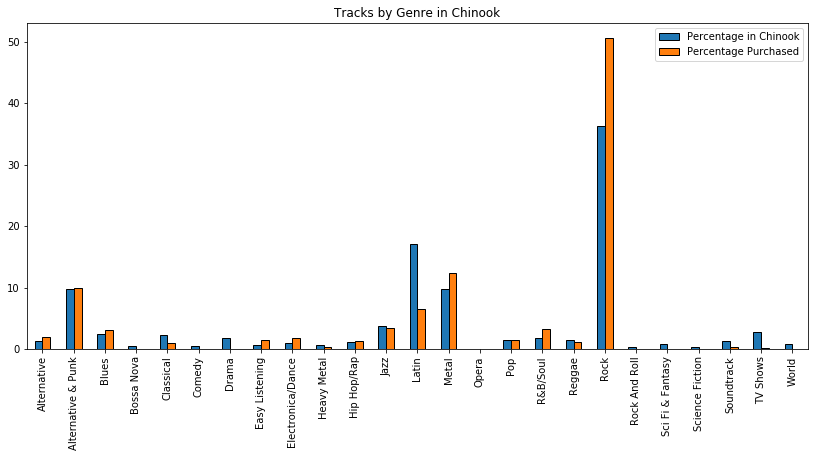

In [545]:
cols = ['number', 'purchased']

fig = plt.figure(figsize = (14, 6))
ax = fig.add_subplot(111)

for c in cols:
    genre_distributions[c] = genre_distributions[c] / genre_distributions[c].sum() * 100

genre_distributions.plot.bar(ax = ax, linewidth = 1, edgecolor = 'black')
ax.set_xlabel('')
ax.set_title('Tracks by Genre in Chinook')
ax.legend(['Percentage in Chinook', 'Percentage Purchased'])

The rock genre is much more represented among the purchased tracks in comparison to the selection of available tracks on Chinook. It is noted that the Latin genre has a good representation in Chinook, but it is not as popular among buying customers. Rock and Roll, Sci Fi & Fantasy, Science Fiction, TV Shows, and World do not seem to be purchased, despite the genres' availability on Chinook.

## Effect of File Protection on Popularity

In [538]:
protected_query = '''
WITH protected_tracks AS
    (
    SELECT
        t.Purchased,
        m.name
    FROM track_purchased_or_not t
    INNER JOIN media_type m ON m.media_type_id = t.media_type_id
    )

SELECT
    SUM(CASE WHEN LOWER(name) LIKE "%protected%" THEN 1 ELSE 0 END) / CAST(COUNT(*) AS FLOAT) * 100 Protected_in_Chinook,
    SUM(CASE WHEN LOWER(name) LIKE "%protected%" AND Purchased = "Yes" THEN 1 ELSE 0 END) /
    CAST(SUM(CASE WHEN Purchased = "Yes" THEN 1 ELSE 0 END) AS FLOAT) * 100 Protected_and_Purchased
FROM protected_tracks'''

#WHERE LOWER(m.name) LIKE "%protected%
run_query(protected_query)

,Protected_in_Chinook,Protected_and_Purchased
0,13.478661,9.020772


A minority of the tracks on Chinook are protected media files. Customers are not inclined to buy tracks if the media files are protected, considering an even smaller percentage of the purchased files are protected files.